In [ ]:
!pip install ijson

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

First, we need to define the path

In [ ]:
# Define the path to related project
PROJECT_PATH = '/content/drive/My Drive/Tugas Akhir'

PROCESSED_DATA_PATH = PROJECT_PATH + '/data/processed'
DATASET_PATH = PROJECT_PATH + '/datasets'

## Import necessary modules

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from wordcloud import WordCloud, STOPWORDS

## Read data

In [ ]:
product_df = pd.read_csv(DATASET_PATH + '/products_uk_clean.csv')
product_df.head()

,id,title,price,brand,color,size,model,material,author,desc,label
0,B087LZNPHS,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,127cm×150cm,NaN,100% Polyester,NaN,color sherpa throw blanket available variety c...,219340
1,B08THFN1KX,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,240mm x 190mm x 60mm,50245-Mat-Perso,Rubber,NaN,competitively priced,283092
2,0804185328,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN,2966
3,B09VBKDBW6,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,NaN,FBA-sealer-black,Acrylonitrile Butadiene Styrene,NaN,aftersalethis handheld food heat sealer powere...,410858
4,B096ZW8B49,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,antifriction customer firsteach box product eq...,320496


In [ ]:
prod_value_count = product_df.isna().sum().reset_index(name='null_value_count')
prod_value_count['null_percentage'] = (prod_value_count['null_value_count']/len(product_df)*100).round(2)
display(prod_value_count)

,index,null_value_count,null_percentage
0,id,0,0.00
1,title,0,0.00
2,price,0,0.00
3,brand,4282,0.86
4,color,122102,24.41
5,size,199088,39.80
6,model,256652,51.31
7,material,201225,40.23
8,author,481284,96.22
9,desc,39321,7.86


## EDA tambahan: cek word cloud untuk brand dan color

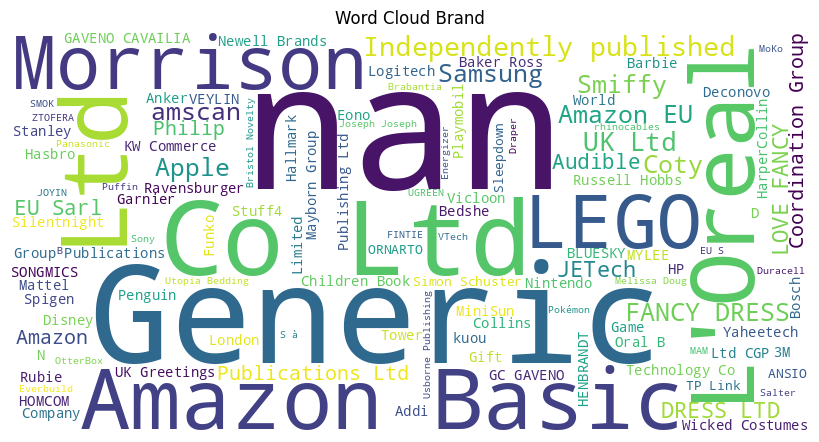

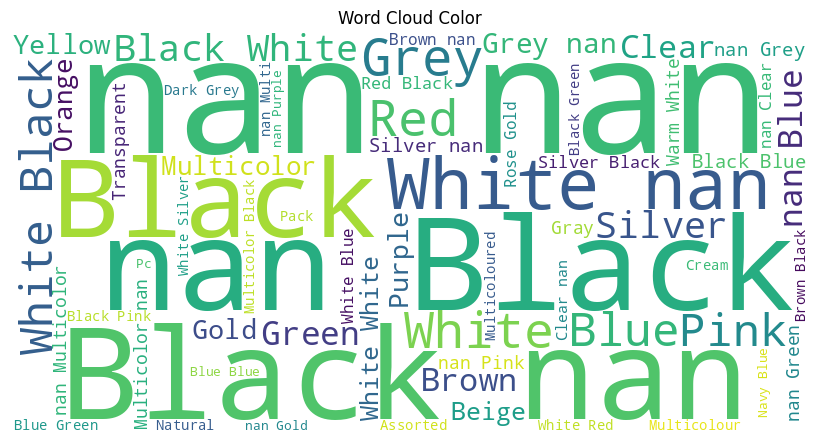

In [ ]:
# prompt: tambah word cloud untuk brand dan color

from wordcloud import WordCloud, STOPWORDS

# Assuming 'product_df' is your DataFrame and contains 'brand' and 'color' columns
text_brand = " ".join(brand for brand in product_df.brand.astype(str))
text_color = " ".join(color for color in product_df.color.astype(str))

wordcloud_brand = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(text_brand)

wordcloud_color = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(text_color)

# Display the generated image:
plt.figure(figsize=(8, 8), facecolor=None)
plt.title("Word Cloud Brand")
plt.imshow(wordcloud_brand)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

plt.figure(figsize=(8, 8), facecolor=None)
plt.title("Word Cloud Color")
plt.imshow(wordcloud_color)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


## Handle Missing Value

Untuk kolom "brand", saya berpikir untuk mengisinya dengan label "Unknown" untuk memberitahu model bahwa produk tersebut tidak memiliki brand sehingga tidak perlu dihitung dalam training (akan menggunakan mask khusus dalam menghitung loss pada training)

In [ ]:
# product_df['brand'] = product_df['brand'].fillna('<unk>')

Untuk produk tanpa deskripsi, juga akan diisi dengan 'unknown'

In [ ]:
# product_df['desc'] = product_df['desc'].fillna('<unk>')

Pada kasus kolom 'author', ia memiliki persentase nilai null sebesar 96%, sehingga perlu di-drop

In [ ]:
product_df.drop('author', axis=1, inplace=True)

Kolom color yang missing akan di-impute dengan value "unknown" untuk menandakan bahwa produk tersebut tidak terlalu concern terkait warna

In [ ]:
# product_df['color'] = product_df['color'].fillna('<unk>')

berdasarkan educated guess, orang-orang tidak terlalu memperhatikan material dalam membeli sebuah produk. Namun, beberapa orang tetap mencari produk berdasarkan material. Oleh karena itu, bahan dari produk seharusnya dapat dilihat pada judul. material akan diconcate dengan title agar material tetap mempengaruhi

Model terkadang juga menjadi pengaruh dari keputusan seseorang membeli sebuah produk. oleh karena itu, maka atribut model akan digabungkan bersama title

In [ ]:
def concat_attributes(row):
    attributes = ['brand', 'color', 'model', 'material']
    result = ''
    for attr in attributes:
        if pd.notna(row[attr]) and len(row[attr]) != '':
            result += f" {row[attr]}"
    return row['title'] + result

karena preferensi size antar barang relatif berbeda (150mm × 150mm tidak lah kecil untuk handphone, namun sangatlah kecil jika berbicara tentang kasur) , maka size perlu didrop dari data

In [ ]:
product_df.drop('size', axis=1, inplace=True)

Menunjukkan df product saat ini

In [ ]:
product_df.head()

,id,title,price,brand,color,model,material,desc,label
0,B087LZNPHS,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,NaN,100% Polyester,color sherpa throw blanket available variety c...,219340
1,B08THFN1KX,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,50245-Mat-Perso,Rubber,competitively priced,283092
2,0804185328,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,2966
3,B09VBKDBW6,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,FBA-sealer-black,Acrylonitrile Butadiene Styrene,aftersalethis handheld food heat sealer powere...,410858
4,B096ZW8B49,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,Alloy Steel,antifriction customer firsteach box product eq...,320496


## Advanced text cleaning

Berikut adalah beberapa fungsi yang digunakan sebagai pembersih teks

In [ ]:
import re
import string

# dalam atribut title, tidak dilakukan pembersihan stop words. Sebab semua kata pada title
# mempengaruhi ketertarikan pengguna

def lowercaser(text):
    return text.lower()

def remove_punctuation(text):
    translator = str.maketrans({p: ' ' for p in string.punctuation})
    return text.translate(translator)

def remove_whitespace(text):
    return " ".join(text.split())

def clean_text(text):
    if pd.isna(text):
        return '<unk>'
    text = lowercaser(text)
    text = remove_punctuation(text)
    text = remove_number(text)
    text = remove_whitespace(text)
    text = remove_unicode(text)
    return text

def remove_number(text):
    return re.sub(r"\d+", "", text)

def remove_unicode(text):
    return text.encode('ascii', 'ignore').decode()

Hal pertama yang dilakukan yaitu membersihkan title.

In [ ]:
product_df['title'] = product_df['title'].apply(clean_text)

Selanjutnya yaitu brand

In [ ]:
product_df['brand'] = product_df['brand'].apply(clean_text)

Selanjutnya yaitu atribut color

In [ ]:
product_df['color'] = product_df['color'].apply(clean_text)

Membersihkan atribut material dan model, lalu menggabungkannya dengan title

In [ ]:
product_df['material'] = product_df['material'].apply(clean_text)
product_df['material'] = product_df['material'].apply(remove_number)
product_df['model'] = product_df['model'].apply(clean_text)
product_df['model'] = product_df['model'].apply(remove_number)
product_df['title'] = product_df.apply(concat_attributes, axis=1)
product_df['desc'] = product_df['desc'].apply(clean_text)
product_df['desc'] = product_df['desc'].apply(remove_number)

Cek lagi sekarang

In [ ]:
product_df.head()

,id,title,price,brand,color,model,material,desc,label
0,B087LZNPHS,sochow sherpa fleece throw blanket double side...,24.99,sochow,teal green,<unk>,polyester,color sherpa throw blanket available variety c...,219340
1,B08THFN1KX,hippowarehouse personalised photo printed mous...,9.95,hippowarehouse,white,mat perso,rubber,competitively priced,283092
2,0804185328,easy recipes for every machine both stovetop a...,16.49,clarkson potter,white,<unk>,<unk>,<unk>,2966
3,B09VBKDBW6,tyhjoy mini bag sealer handheld vacuum heat se...,11.99,tyhjoy,black,fba sealer black,acrylonitrile butadiene styrene,aftersalethis handheld food heat sealer powere...,410858
4,B096ZW8B49,lucosobie steering wheel lock car anti theft d...,26.99,lucosobie,black,<unk>,alloy steel,antifriction customer firsteach box product eq...,320496


## Drop unused features

In [ ]:
product_df.drop(columns=['model', 'material', 'desc', 'brand', 'color'], inplace=True)


## Remove duplicate word in title

In [ ]:
product_df['title'] = product_df['title'].apply(lambda x: ' '.join(set(x.split())))

### Clean again by removing words that have length of one

In [ ]:
product_df['title'] = product_df['title'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

## Save cleaned product data

In [ ]:
# create dir if it not exists
if not os.path.exists(PROCESSED_DATA_PATH):
    os.makedirs(PROCESSED_DATA_PATH)
product_df.to_csv(PROCESSED_DATA_PATH + '/products_uk_cleaner.csv', index=False)

Load the product data if it exists

In [ ]:
try:
    product_df = pd.read_csv(PROCESSED_DATA_PATH + '/products_uk_cleaner.csv')
except FileNotFoundError:
    print("File not found")

In [ ]:
product_df.head()

,id,title,price,label
0,B087LZNPHS,green throw sochow cmcm teal polyester luxurio...,24.99,219340
1,B08THFN1KX,present pad rubber fathers option perso office...,9.95,283092
2,0804185328,electric clarkson potter stovetop for cookbook...,16.49,2966
3,B09VBKDBW6,styrene portable sealer included fresh sealing...,11.99,410858
4,B096ZW8B49,lock stretchable wheel anti keys to device adj...,26.99,320496


## Join data sequence dengan produk

In [ ]:
sequences = pd.read_csv(DATASET_PATH + '/sessions_transformed.csv')
sequences.head()

,session_id,sequence
0,0,"[489206, 489237, 142933, 188025, 188028]"
1,1,"[133985, 138876, 315348]"
2,2,"[19817, 129680, 129680, 20979]"
3,3,"[443147, 12620, 12621]"
4,4,"[55082, 55082, 57935, 359096, 139532]"


untuk mempermudah join, maka data akan dikonversi menjadi format JSON

In [ ]:
import json
from tqdm import tqdm
import gc
from decimal import Decimal

def convert_and_concat_with_product_json(sessions_df, product_df, output_file='converted_sessions.json', batch_size=1000):
    # Convert product_df to a dictionary for quick lookup
    product_dict = product_df.set_index('label').to_dict(orient='index')

    with open(output_file, 'w') as f:
        f.write("[\n")  # Start JSON array

        first = True
        buffer = []

        for idx, (_, row) in enumerate(tqdm(sessions_df.iterrows(), total=len(sessions_df), desc="Processing sessions")):
            session_id = row['session_id']
            sequence = json.loads(row['sequence'])

            enriched_sequence = []
            for label in sequence:
                if label in product_dict:
                    product_info = product_dict[label].copy()

                    # Convert NaN to None
                    for key in product_info:
                        val = product_info[key]
                        if pd.isna(val):
                            product_info[key] = None
                        elif isinstance(val, Decimal):
                            product_info[key] = float(val)

                    product_info['label'] = label

                    enriched_sequence.append(product_info)

            buffer.append({
                "session_id": session_id,
                "sequence": enriched_sequence,
                "length": len(enriched_sequence)
            })

            # Write in batches to avoid using too much memory
            if len(buffer) >= batch_size:
                for item in buffer:
                    if not first:
                        f.write(",\n")
                    f.write(json.dumps(item))
                    first = False
                buffer = []

        # Write remaining buffer
        for item in buffer:
            if not first:
                f.write(",\n")
            f.write(json.dumps(item))
            first = False

        f.write("\n]")  # Close JSON array

    # Deallocate all the memory used in this function (because Jupyter Notebook can handle
    # garbage collection properly)
    del buffer, product_dict
    print("Deallocating memory...")
    print(f"Deallocate {gc.collect()}")

    print(f"✅ Data saved to {output_file}")


In [ ]:
convert_and_concat_with_product_json(sequences, product_df, PROCESSED_DATA_PATH + '/data_joined.json', 2000)

Processing sessions: 100%|██████████| 1182181/1182181 [02:24<00:00, 8157.71it/s] 


Deallocating memory...
Deallocate 0
✅ Data saved to /content/drive/My Drive/Tugas Akhir/data/processed/data_joined.json


## Load the already written json file

In [ ]:
import ijson

class DecimalEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Decimal):
            return float(obj)
        return super(DecimalEncoder, self).default(obj)


file_path = PROCESSED_DATA_PATH + '/data_joined.json'
head = []

with open(file_path, 'r') as f:
    objects = ijson.items(f, 'item')

    for i, obj in enumerate(objects):
        if i >= 100:
            break
        head.append(obj)


# Now you can inspect the first 100 objects
for i, item in enumerate(head[:5]):
    print(f"\n[{i}] session_id: {item['session_id']} | length: {item['length']}")
    print("sequence:")
    print(json.dumps(item['sequence'], indent=4, cls=DecimalEncoder))
    print("---------------------------------------")


[0] session_id: 0 | length: 5
sequence:
[
    {
        "id": "B0BFDL54Y7",
        "title": "salad in food cutter slicer veg vegetable with wokii potato container garlic for onion dicer butadi blue chopper acrylonitrile <unk> mini",
        "price": 15.99,
        "label": 489206
    },
    {
        "id": "B0BFDR9X13",
        "title": "salad in grey food cutter slicer veg vegetable with wokii potato container garlic for onion dicer butadi green chopper acrylonitrile <unk> mini",
        "price": 14.99,
        "label": 489237
    },
    {
        "id": "B07J4WF8VH",
        "title": "interchangeable salad food stainless cutter set slicer fruits inserts vegetable with potato garlic steel onion vinsani chopper white cheese blade kitchen <unk>",
        "price": 16.99,
        "label": 142933
    },
    {
        "id": "B07Y21LDJX",
        "title": "abs replaceable function separator premium in stainless cutter slicer fruits julienne vegetable plastic grater with potato steel for ado

In [ ]:
import gc
gc.collect()

165